<a href="https://colab.research.google.com/github/bdgToji/VNP/blob/main/KOL2_Clustering_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Clustering: Generate clusters for sentiment analysis of the bitcoin tweets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph

In [10]:
!pip install transformers

# Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/VNP/BTC_Tweets_Sentiment.csv')

In [5]:
df.head()

,id,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,New_Sentiment_Score,New_Sentiment_State,BERT Labels
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,0.000000,0.0,1
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0.0,0.000000,0.0,0
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.136364,1.0,0
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.400000,1.0,0
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1.0,0.468182,1.0,0


In [7]:
df = df.drop(columns=['id','sent_score','New_Sentiment_Score','New_Sentiment_State','BERT Labels'])

In [8]:
df.head()

,Date,Tweet,Screen_name,Source,Link,Sentiment
0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral']
1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral']
2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive']


In [13]:
encoder = LabelEncoder()

df['Sentiment'] =encoder.fit_transform(df['Sentiment'])

In [14]:
df['Sentiment'].value_counts()

Sentiment
2    22937
1    21932
0     5983
Name: count, dtype: int64

# Universal Sentence Encoder

In [15]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [18]:
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(df.Tweet.values)

In [19]:
message_embeddings

<tf.Tensor: shape=(50852, 512), dtype=float32, numpy=
array([[-0.03834763, -0.04177495, -0.03000215, ...,  0.05547818,
        -0.05757411, -0.05747128],
       [-0.00023587, -0.04965301, -0.04544644, ..., -0.00699701,
        -0.0817619 , -0.06738114],
       [-0.00882475, -0.06427665, -0.06390414, ...,  0.05352812,
        -0.06909753, -0.0684047 ],
       ...,
       [-0.03637782, -0.07333582, -0.02006671, ...,  0.00748271,
        -0.06006524, -0.0688739 ],
       [-0.01435385, -0.0501017 ,  0.00692282, ..., -0.01416572,
        -0.07574023, -0.07719906],
       [-0.00828403, -0.08008461, -0.03335601, ..., -0.01549363,
        -0.03189274, -0.02582982]], dtype=float32)>

# K-Means Clustering

In [20]:
km = KMeans(n_clusters=3)
km.fit(message_embeddings)
clusters = km.labels_.tolist()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
data = message_embeddings
pca = PCA(2)

#Transform the data
df_new = pca.fit_transform(data)

In [22]:
#Initialize the class object
kmeans = KMeans(n_clusters=3)

#predict the labels of clusters.
label = kmeans.fit_predict(df_new)

#Getting unique labels
u_labels = np.unique(label)

labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


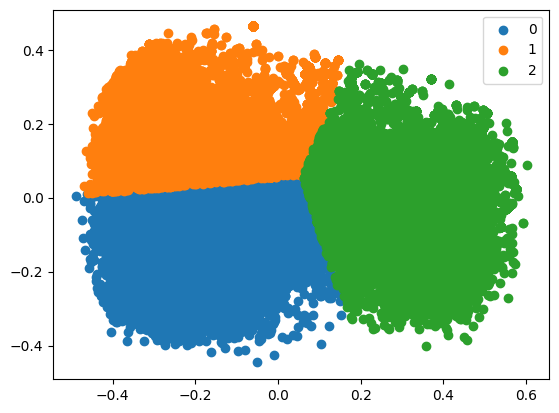

In [23]:
%matplotlib inline
#plotting the results:
for i in u_labels:
    plt.scatter(df_new[label == i , 0] , df_new[label == i , 1] , label = i)
plt.legend()
plt.show()

# Agglomerative Clustering

In [24]:
data = message_embeddings
pca = PCA(2)

#Transform the data
df_new = pca.fit_transform(data)

In [25]:
connectivity = kneighbors_graph(df_new, n_neighbors=10, include_self=False)

In [26]:
model = AgglomerativeClustering(n_clusters=3, connectivity=connectivity, linkage='ward').fit(df_new)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 29 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


In [27]:
clusters = model.labels_.tolist()

In [28]:
model.labels_

array([2, 2, 0, ..., 0, 2, 0])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 29 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


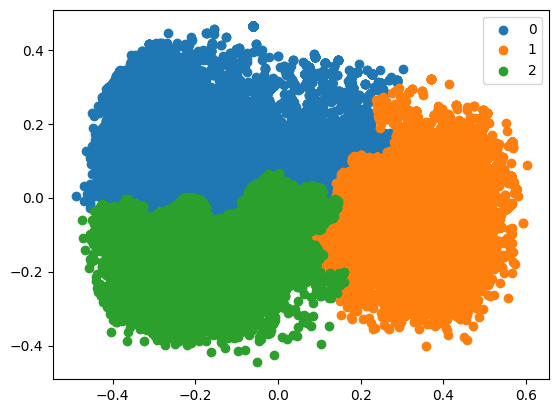

In [29]:
%matplotlib inline

label = model.fit_predict(df_new)

u_labels = np.unique(label)

#plotting the results:
for i in u_labels:
    plt.scatter(df_new[label == i , 0] , df_new[label == i , 1] , label = i)
plt.legend()
plt.show()